# Create Linear Classifier
**Steps**

1) Import Libraries  

2) Prepare and Process the data 

3) Define Variables 

4) Define Functions to Calculate Loss and Accuracy

5) Define Linear Classifier Function

6) Plot the Data 

7) Plot Resulting Images

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

# For CIFAR10
K = len(np.unique(y_train)) # Number of Classes; 10
Ntr = x_train.shape[0]  # Number of training samples; 50,000 
Nte = x_test.shape[0]   # Number of test samples; 10,000
Din = 3072 # CIFAR10

# Normalize pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0)   # Mean of the Image pixels 
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert 1-dimentional array class arrays to 10-dimentional class matrices 
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)


In [24]:
std=1e-6
w1 = std*np.random.randn(Din, K)
b1 = np.zeros(K)

#define variables 
batch_size = Ntr # Take all training data at onece; batch geadient decsent 
iterations = 300
lr = 0.01
lr_decay= 0.99
reg = 5e-6
loss_history = []
train_acc_history = []
val_acc_history = []

In [5]:
#Define a function to calculate the loss
def calc_loss(y, y_pred, w1, w2 = 0):
    batch_size=y_pred.shape[0]
    loss = 1./batch_size*np.square(y_pred - y).sum() + reg*(np.sum(w2*w2) + np.sum(w1*w1))
    return loss

In [6]:

def accuracy(y_pred,y):
    batch_size=y_pred.shape[0]
    K=y_pred.shape[1]
    acc=1-(1/(batch_size*K))*(np.abs(np.argmax(y,axis=1)-np.argmax(y_pred,axis=1))).sum() #Take max value in y and y_pred and take absolte value of the differece 
    return acc

In [7]:
#linear classifier
def classifier(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg):
    Ntr = x_train.shape[0]
    Nte = x_test.shape[0]

    loss_history = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    std=1e-5
    w1 = std*np.random.randn(Din, K) #create hypothesis function
    b1 = np.zeros(K)

    for t in range(iterations):
        indices = np.arange(Ntr)
        rng.shuffle(indices)
        x=x_train[indices]
        y=y_train[indices]

        #forward pass
        y_pred=x.dot(w1)+b1
        y_pred_test=x_test.dot(w1)+b1

        #Calculate training and validation losses
        train_loss=calc_loss(y_pred,y,w1)
        test_loss=calc_loss(y_pred_test,y_test,w1)
        loss_history.append(train_loss)
        
        #Calculate training and validation accuracies
        train_acc=accuracy(y_pred,y)
        train_acc_history.append(train_acc)
        test_acc=accuracy(y_pred_test,y_test)
        val_acc_history.append(test_acc)

        if t%10 == 0:
            print('Epoch %3d/%d:==> Train Loss= %f | Test Loss= %f | Train Accuracy= %f | Test Accuracy= %f' % (t,iterations,train_loss,test_loss,train_acc,test_acc))

        # Backward pass
        dy_pred=(1./batch_size)*2.0*(y_pred-y)
        dw1=x.T.dot(dy_pred)+reg*w1
        db1=dy_pred.sum(axis=0)
        w1-=lr*dw1
        b1-=lr*db1
        lr*=lr_decay
    return w1,b1,loss_history,train_acc_history,val_acc_history

In [25]:
w1,b1,loss_history,train_acc_history,val_acc_history=classifier(x_train, y_train, x_test, y_test, K, Din, lr, lr_decay, reg)

Epoch   0/300:==> Train Loss= 0.999985 | Test Loss= 0.999981 | Train Accuracy= 0.677112 | Test Accuracy= 0.676900
Epoch  10/300:==> Train Loss= 0.893988 | Test Loss= 0.893443 | Train Accuracy= 0.751996 | Test Accuracy= 0.754520
Epoch  20/300:==> Train Loss= 0.863946 | Test Loss= 0.863638 | Train Accuracy= 0.759150 | Test Accuracy= 0.762210
Epoch  30/300:==> Train Loss= 0.845986 | Test Loss= 0.845830 | Train Accuracy= 0.761938 | Test Accuracy= 0.767490
Epoch  40/300:==> Train Loss= 0.834140 | Test Loss= 0.834103 | Train Accuracy= 0.764160 | Test Accuracy= 0.769200
Epoch  50/300:==> Train Loss= 0.825931 | Test Loss= 0.825998 | Train Accuracy= 0.765942 | Test Accuracy= 0.770710
Epoch  60/300:==> Train Loss= 0.820037 | Test Loss= 0.820196 | Train Accuracy= 0.767198 | Test Accuracy= 0.771220
Epoch  70/300:==> Train Loss= 0.815680 | Test Loss= 0.815925 | Train Accuracy= 0.767878 | Test Accuracy= 0.771600
Epoch  80/300:==> Train Loss= 0.812379 | Test Loss= 0.812701 | Train Accuracy= 0.768654 

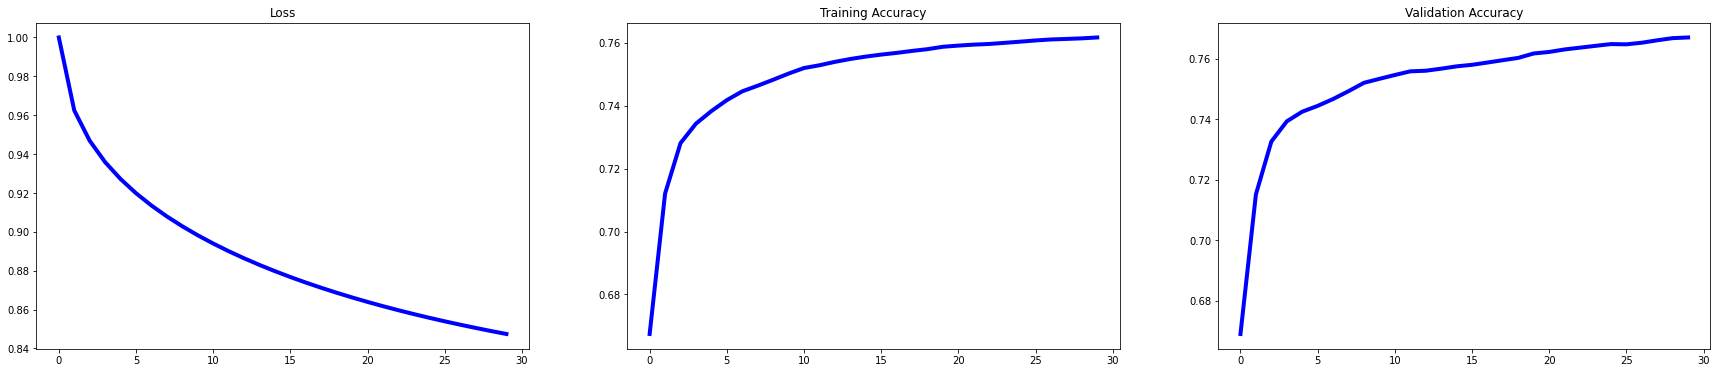

In [9]:
fig, axes  = plt.subplots(1,4, sharex='all', sharey='all', figsize=(30,6))
items = {"Loss":loss_history, "Training Accuracy":train_acc_history,"Validation Accuracy": val_acc_history}

graph = 1
for key in items.keys():
    plt.subplot(1,3,location);plt.plot(items[key], color='#0000ff', linewidth=4)
    plt.title(key)
    graph+=1

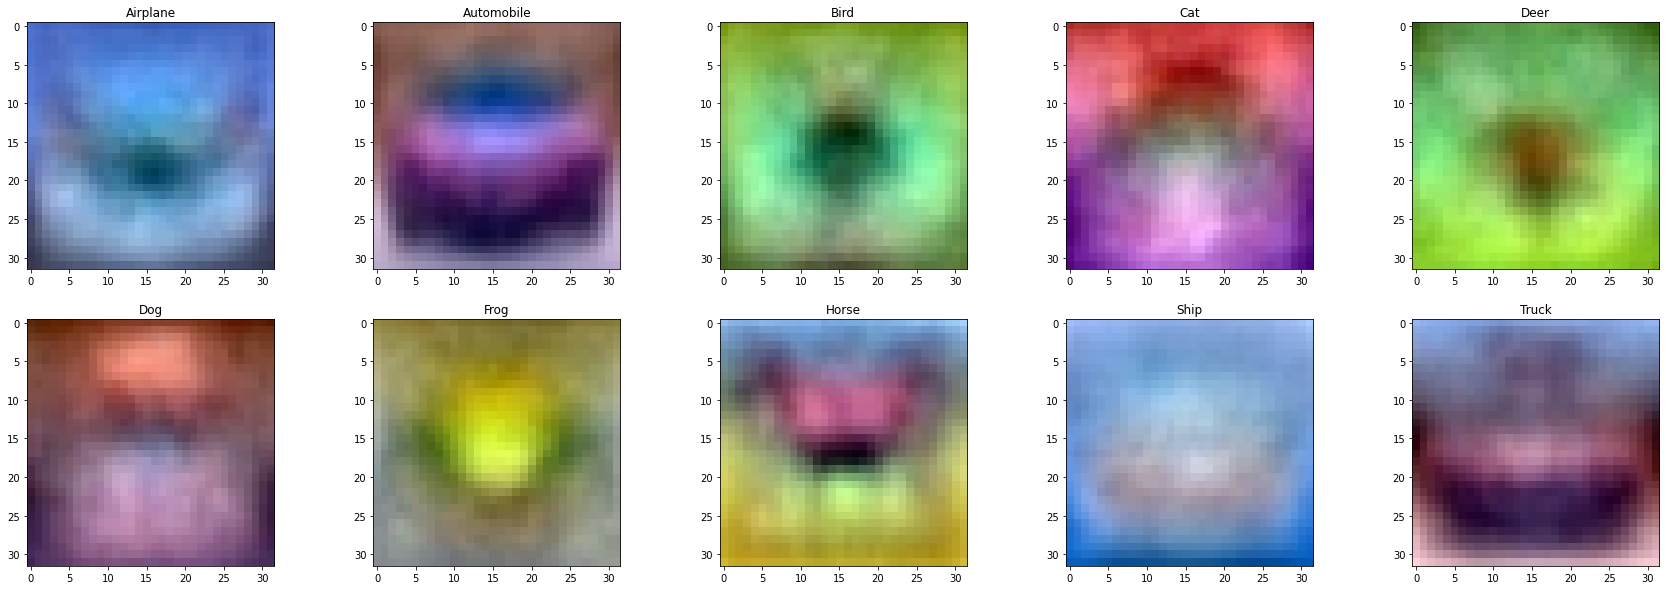

In [23]:
import cv2 as cv
images=[]
for i in range(w1.shape[1]):
    #images.append(np.reshape(w1[:,i]*255,(32,32,3))+np.reshape(mean_image,(32,32,3)))
    temp=np.reshape(w1[:,i]*255,(32,32,3))
    temp=cv.normalize(temp, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    images.append(temp)
lst = [['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer'],['Dog','Frog','Horse','Ship','Truck']]
fig,ax=plt.subplots(2,5,figsize=(30,10))
for i in range(2):
    for j in range(5):
        ax[i,j].set_title(lst[i][j])
        ax[i,j].imshow(images[i*5+j],vmin=0,vmax=255)
plt.show()